In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
G = scipy.signal.lti([1], [15, 8, 1]) # Transfer function of the model

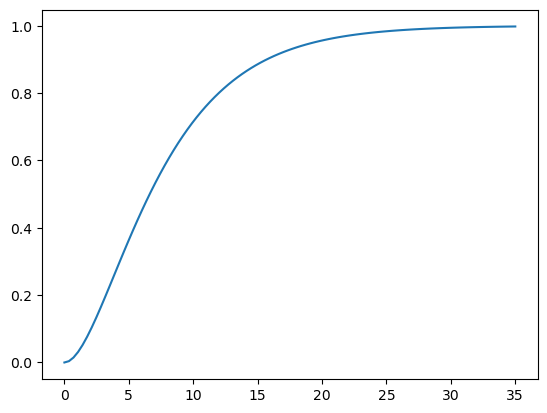

In [3]:
plt.plot(*G.step())

Our goal is to find out what manipulations must be made (changes to 
) in order to get the system to follow a specific desired trajectory (which we will call 
 for the reference trajectory). We will allow the controller to make a certain number of moves. This is called the control horizon, 
. We will the observe the effect of this set of moves (called a "move plan") for time called the prediction horizon (
).

In [4]:
M = 10  # Control horizon
P = 20  # Prediction horizon
DeltaT = 1  # Sampling rate

In [5]:
tcontinuous = numpy.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

We choose a first order setpoint response similar to DS or Dahlin

In [6]:
tau_c = 1
r = 1 - numpy.exp(-tpredict/tau_c) #trajectory to follow?

In [21]:
u = numpy.ones(M) # Intial guess of the inputs
x0 = numpy.zeros(G.to_ss().A.shape[0]) # initial state
umin = -3
umax = 3

In [8]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return numpy.concatenate([u, numpy.repeat(u[-1], P-M)])

In [9]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

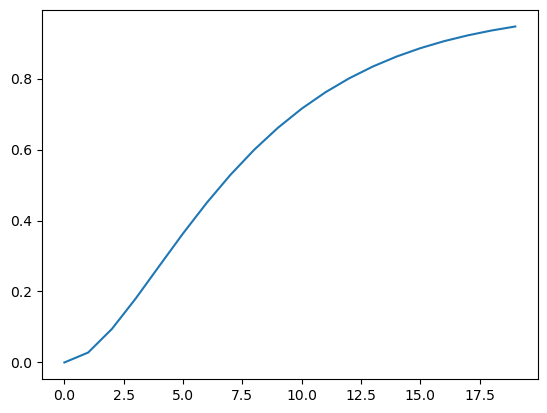

In [10]:
plt.plot(tpredict, prediction(extend(u)))

In [22]:
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
def constraint(u,umin,umax):
    return numpy.concatenate((umax-u,u-umin))


Now we figure out a set of moves which will minimise our objective function

In [23]:
constraint_eq = {'type': 'ineq', 'fun': constraint, 'args': (umin, umax)}
result = scipy.optimize.minimize(objective, u,method='SLSQP',constraints=constraint_eq)#minimize objective function over the input. 
uopt = result.x
result.fun

0.835269259314096

In [13]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)] #change u to continous 

In [14]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.legend()

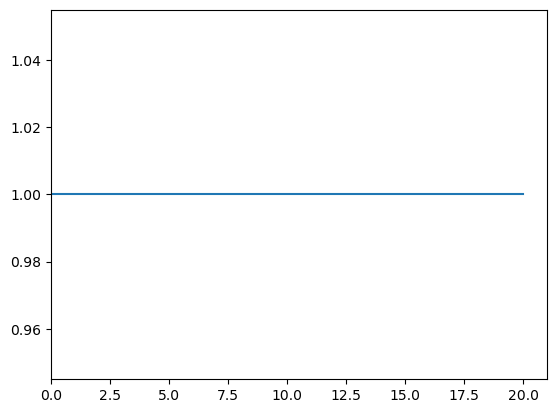

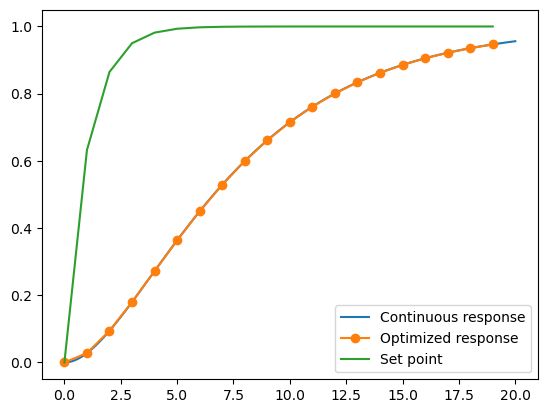

In [15]:
plotoutput(ucont, uopt)

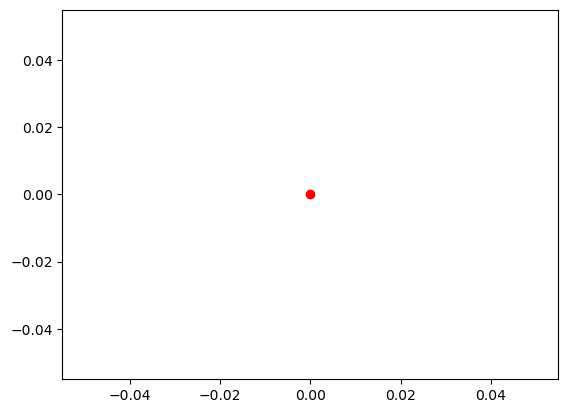

In [16]:
plt.plot(0,0,'ro')
plt.show()
